## Neural network deployment notebook: generalized surrogate model based on ATC-138
### Hazard level: any, impeding factors ON
Evaluate and optimize in one notebook.
Omar Issa, Stanford University (Summer 2022)

In [10]:
# Import packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, explained_variance_score,r2_score
import pickle
import time
import copy
import random
font = {'fontname':'Source sans pro'}

import pymoo
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.ga import GA

In [40]:
class sumXi_constrained(ElementwiseProblem):

    def __init__(self):
        xl = np.concatenate((np.ones((1,5)), np.ones((1,36))*1), axis = None)
        xu = np.concatenate((np.ones((1,5)) * 1.0000000001, np.ones((1,36)) * 3), axis = None)
        super().__init__(n_var=41, n_obj=1, n_constr=0, xl=xl, xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        x = x.reshape(1,-1)
        out["F"] = np.sum(x) + 10E8*(max( float(mlp.predict(scaler.transform(np.concatenate((edp_input, x), axis = 1)))) - T_target,0 ))**2

T_array        = np.linspace(7,182,26)
RP_array       = np.array([475]) 
n_trial_array  = np.array([5])
Ie_array       = np.array([1.00, 1.50, 2.00])

solution_dict_best = dict()
solution_dict_avg  = dict()
solution_dict_all  = dict()

# Loop over n_trials    
for n_trial in n_trial_array:

    sol_all      = np.zeros((len(Ie_array), len(RP_array), len(T_array), 41, n_trial))
    sol_best     = np.zeros((len(Ie_array), len(RP_array), 41, len(T_array)))
    sol_avg      = np.zeros((len(Ie_array), len(RP_array), 41, len(T_array)))

    for Ie_idx in np.arange(len(Ie_array)):
        for RP_idx in np.arange(len(RP_array)):
            for t_idx in np.arange(len(T_array)):
                solution =  np.ones((41, 1)) * 999
                for n in np.arange(n_trial):
                    
                    if(Ie_array[Ie_idx] == 1.00):
                        edp_input = np.array([[0.0180361, 0.01825795, 0.01739635, 223.101, 325.643, 351.9045, 408.205]])
                    elif(Ie_array[Ie_idx] == 1.50):
                        edp_input = np.array([[0.0118321, 0.0142595, 0.01641215, 223.101, 342.76, 421.626, 498.4165]])
                    elif(Ie_array[Ie_idx] == 2.00):
                        edp_input = np.array([[0.01108845, 0.01346775, 0.0140311, 223.101, 374.672, 481.883, 684.872]])
                    
                    T_target = T_array[t_idx]

                    problem = sumXi_constrained()

                    algorithm = DE(
                        pop_size=41 * 10,
                        sampling=LHS(),
                        variant="DE/best/1/bin",
                        F = 0.8,
                        CR = 0.9,
                        dither="vector",
                        jitter=False
                    )
                    res = minimize(problem,
                                   algorithm,
                                   verbose=False)

                    sol_all[Ie_idx][RP_idx][t_idx][:,n]  = res.X

                    if sum(res.X) < sum(solution):
                        solution = res.X

                sol_best[Ie_idx][RP_idx][:,t_idx] = solution
                sol_avg[Ie_idx][RP_idx][:,t_idx]  = np.mean(sol_all[Ie_idx][RP_idx][t_idx].reshape(41, n_trial), axis = 1)

            solution_dict_all[n_trial] = sol_all
            print("N = " + str(n_trial) + ". Optimization for Ie = " + str(Ie_array[Ie_idx]) + " and " + str(RP_array[RP_idx]) + " EDP RP comprising of "+ str(len(T_array)) + " targets is complete.")

        solution_dict_best[n_trial] = sol_best
        solution_dict_avg[n_trial]  = sol_avg     



N = 5. Optimization for Ie = 1.0 and 475 EDP RP comprising of 26 targets is complete.
N = 5. Optimization for Ie = 1.5 and 475 EDP RP comprising of 26 targets is complete.
N = 5. Optimization for Ie = 2.0 and 475 EDP RP comprising of 26 targets is complete.


## Save solution in a pickle file

In [24]:
# Save solution in pickle file
with open('saved_optima/solution_dict_all_DE.pkl','wb') as f:
        pickle.dump(solution_dict_all,f)
with open('saved_optima/solution_dict_best_DE.pkl','wb') as f:
        pickle.dump(solution_dict_best,f)        
with open('saved_optima/solution_dict_avg_DE.pkl','wb') as f:
        pickle.dump(solution_dict_avg,f)        
        

In [37]:
# Open solution in pickle file
solution_dict_all  = pickle.load(open('saved_optima/solution_dict_all_DE.pkl','rb'))
solution_dict_best = pickle.load(open('saved_optima/solution_dict_best_DE.pkl','rb'))     
solution_dict_avg  = pickle.load(open('saved_optima/solution_dict_avg_DE.pkl','rb'))        

## Plot solution

In [58]:
# Select solution to plot
n_trial = 10
RP_idx  = 0
Ie_idx  = 0
t_idx   = (T_array == 21) # target time

disp_sol = pd.DataFrame(solution_dict_best[n_trial][Ie_idx][RP_idx][:,t_idx])

# Add component ID to the beginning of the dataframe
pm = pd.read_csv('LowRise_PM_v2.csv')
optimum_fragility_mod = pd.concat([disp_sol], axis=1)
optimum_fragility_mod.index = pm.Summary
optimum_fragility_mod.index.bnames = ['component']
optimum_fragility_mod.columns = T_array[t_idx]
optimum_fragility_mod

## Draw a heatmap with the numeric values in each cell
cmap = sns.cm.rocket_r
f, ax = plt.subplots(figsize=(1.5, 10))
# plt.title('Component enhancements for RP = ' + str(return_period) + 'years at $T_{target} = $' + str(T_target) + ' days', pad = 30)
sns.heatmap(optimum_fragility_mod, annot=True, linewidths=0.5, ax=ax, cmap=cmap, vmin=1, vmax=3, cbar_kws = dict(use_gridspec=False,location="right"))
plt.title('Component enhancements for $RP = $' + str(RP_array[RP_idx]) + ' years for various target times', pad = 30)
plt.xlabel('Scale applied to component capacity ' + r'$ \theta $')
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)



IndexError: boolean index did not match indexed array along dimension 1; dimension is 9 but corresponding boolean dimension is 26

In [59]:
# Loop over each of the target times and pull out best (single Ie, multi-target)

Ie_idx = 0

disp_sol = pd.DataFrame(solution_dict_best[n_trial][Ie_idx][RP_idx][:,:])


# Add component ID to the beginning of the dataframe
pm = pd.read_csv('LowRise_PM_v2.csv')
optimum_fragility_mod = pd.concat([disp_sol], axis=1)
optimum_fragility_mod.index = pm.Summary
optimum_fragility_mod.index.bnames = ['component']
optimum_fragility_mod.columns = T_array
optimum_fragility_mod

## Draw a heatmap with the numeric values in each cell
cmap = sns.cm.rocket_r
f, ax = plt.subplots(figsize=(7, 10))
# plt.title('Component enhancements for RP = ' + str(return_period) + 'years at $T_{target} = $' + str(T_target) + ' days', pad = 30)
sns.heatmap(optimum_fragility_mod, annot=True, linewidths=0.5, ax=ax, cmap=cmap, vmin=1, vmax=3, cbar_kws = dict(use_gridspec=False,location="right"))
plt.title('Component enhancements for $RP = $' + str(RP_array[RP_idx]) + ' years for various target times', pad = 30)
plt.xlabel('Scale applied to component capacity ' + r'$ \theta $')
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)






ValueError: Length mismatch: Expected axis has 9 elements, new values have 26 elements

In [44]:
# Plotting 

# Pre-allocate memory for the solution
fx_Ie = np.zeros((len(Ie_array),len(T_array)))

for Ie_idx in np.arange(len(Ie_array)):
    for T_idx in np.arange(len(T_array)):
        fx_Ie[Ie_idx, T_idx] = sum(solution_dict_best[n_trial][Ie_idx][RP_idx][:,T_idx])/41
 


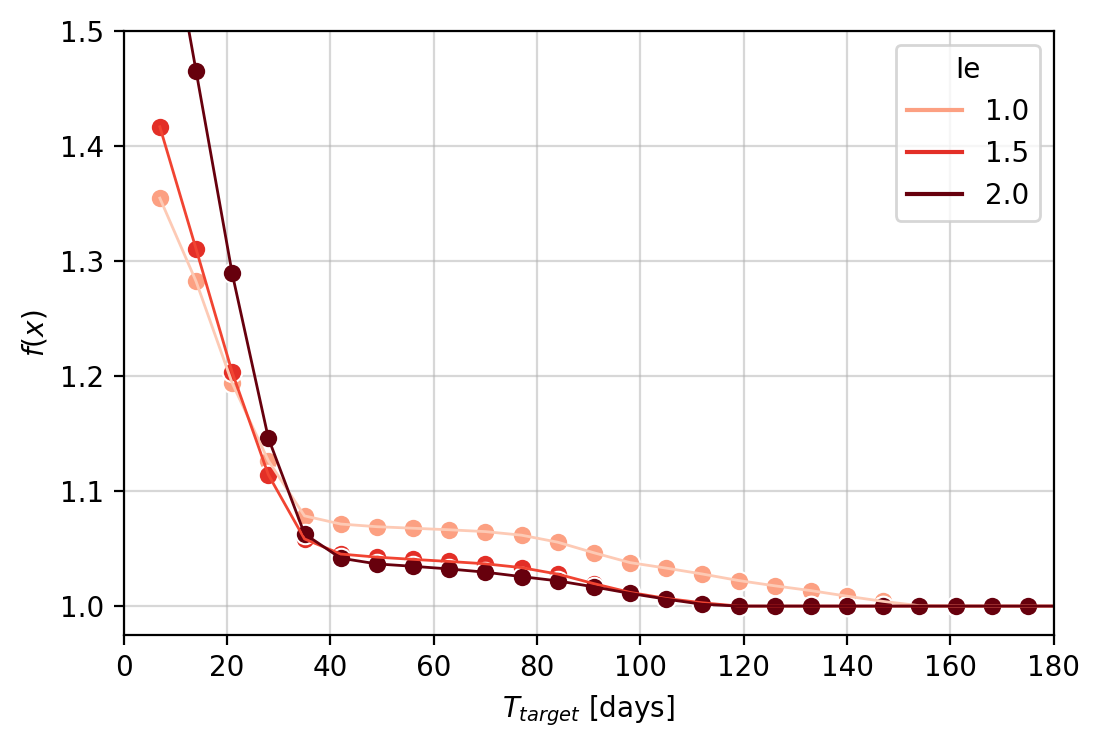

In [45]:
df_fx_Ie = pd.DataFrame(np.transpose(fx_Ie))
df_fx_Ie.columns = Ie_array
df_fx_Ie.columns.name = 'Ie'
df_fx_Ie.index   = T_array
df_fx_Ie.index.name = 'T'


df_fx_Ie = df_fx_Ie.reset_index().melt(id_vars=['T']).set_index(['T', 'Ie'])

df_fx_Ie

f, ax = plt.subplots(figsize=(6, 4), dpi=200)
ax = sns.lineplot(data=df_fx_Ie, x = 'T' , y='value', linewidth = 1.0, hue = 'Ie', marker = 'o', markersize=7,  palette = "Reds", hue_norm = (0.5,2), dashes=False, linestyle='', alpha=1)
sns.lineplot(data=df_fx_Ie, x = 'T' , y='value', linewidth = 1.0, hue = 'Ie', palette = "Reds", hue_norm = (0.75,2), legend=False, ax=ax)
plt.ylim([0.975, 1.5])
plt.xlim([0, 180])
plt.xlabel('$T_{target}$ [days]')
plt.ylabel('$f(x)$')
plt.grid(alpha = 0.5)

plt.savefig("fx.svg")


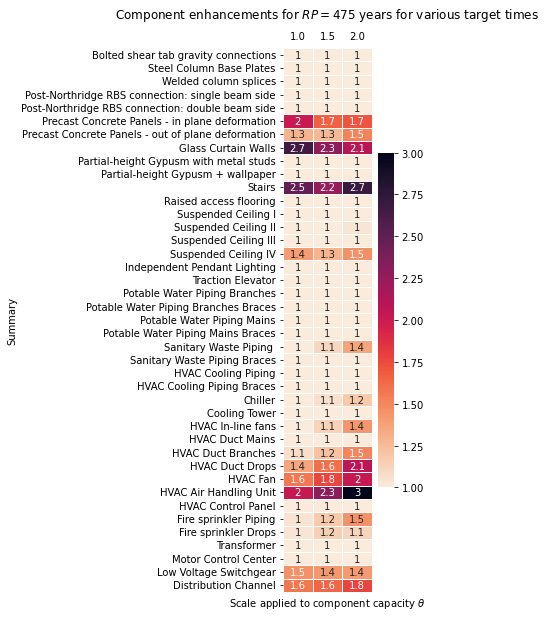

In [47]:
# Plot optima for specific target times across Ie values

n_trial = 5
RP_idx  = 0
t_idx   = (T_array == 21)

disp_sol_Ie1_00 = pd.DataFrame(solution_dict_best[n_trial][0][RP_idx][:,t_idx])
disp_sol_Ie1_50 = pd.DataFrame(solution_dict_best[n_trial][1][RP_idx][:,t_idx])
disp_sol_Ie2_00 = pd.DataFrame(solution_dict_best[n_trial][2][RP_idx][:,t_idx])


# Add component ID to the beginning of the dataframe
pm = pd.read_csv('LowRise_PM_v2.csv')
optimum_fragility_mod = pd.concat([disp_sol_Ie1_00, disp_sol_Ie1_50, disp_sol_Ie2_00], axis=1)
optimum_fragility_mod.index = pm.Summary
optimum_fragility_mod.index.bnames = ['component']
optimum_fragility_mod.columns = Ie_array
optimum_fragility_mod

## Draw a heatmap with the numeric values in each cell
cmap = sns.cm.rocket_r
f, ax = plt.subplots(figsize=(2, 10))
# plt.title('Component enhancements for RP = ' + str(return_period) + 'years at $T_{target} = $' + str(T_target) + ' days', pad = 30)
sns.heatmap(optimum_fragility_mod, annot=True, linewidths=0.5, ax=ax, cmap=cmap, vmin=1, vmax=3, cbar_kws = dict(use_gridspec=False,location="right"))
plt.title('Component enhancements for $RP = $' + str(RP_array[RP_idx]) + ' years for various target times', pad = 30)
plt.xlabel('Scale applied to component capacity ' + r'$ \theta $')
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)


plt.savefig("21.svg", bbox_inches = 'tight')








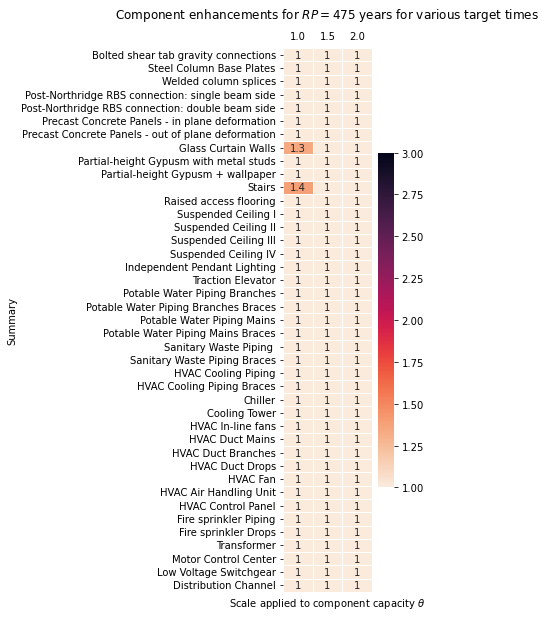

In [53]:
# Plot optima for specific target times across Ie values

n_trial = 5
RP_idx  = 0
t_idx   = (T_array == 126)

disp_sol_Ie1_00 = pd.DataFrame(solution_dict_best[n_trial][0][RP_idx][:,t_idx])
disp_sol_Ie1_50 = pd.DataFrame(solution_dict_best[n_trial][1][RP_idx][:,t_idx])
disp_sol_Ie2_00 = pd.DataFrame(solution_dict_best[n_trial][2][RP_idx][:,t_idx])


# Add component ID to the beginning of the dataframe
pm = pd.read_csv('LowRise_PM_v2.csv')
optimum_fragility_mod = pd.concat([disp_sol_Ie1_00, disp_sol_Ie1_50, disp_sol_Ie2_00], axis=1)
optimum_fragility_mod.index = pm.Summary
optimum_fragility_mod.index.bnames = ['component']
optimum_fragility_mod.columns = Ie_array
optimum_fragility_mod

## Draw a heatmap with the numeric values in each cell
cmap = sns.cm.rocket_r
f, ax = plt.subplots(figsize=(2, 10))
# plt.title('Component enhancements for RP = ' + str(return_period) + 'years at $T_{target} = $' + str(T_target) + ' days', pad = 30)
sns.heatmap(optimum_fragility_mod, annot=True, linewidths=0.5, ax=ax, cmap=cmap, vmin=1, vmax=3, cbar_kws = dict(use_gridspec=False,location="right"))
plt.title('Component enhancements for $RP = $' + str(RP_array[RP_idx]) + ' years for various target times', pad = 30)
plt.xlabel('Scale applied to component capacity ' + r'$ \theta $')
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)









